# Exploring New Alloy Systems with Pymatgen!

The goal of this tutorial is to learn how to make a new alloy material with pymatgen, using an existing material as an end-point. This is one of many strategies that is enabled by pymatgen for discovery of new materials. We will then compare properties of this alloy to the end point system.

#### packages you will need

In [1]:
from pymatgen import MPRester
import pandas as pd
import numpy as np

Now we can initiate the MP Rester API by creating an object mpr:

In [3]:
mpr = MPRester() # YOUR API KEY GOES IN THIS FUNCTION! as a string.

# 1. select a test-case system

In this notebook we will focus on cubic zincblende ZnS, a wide band gap (transparent) semiconductor. In my PhD research I study study p-type transparent semiconductors, so I will pose the question: how can we use ZnS as a starting point to create a p-type transparent semiconductor?
\

\
This is the associated Materials Project id (mpid):

In [4]:
mpid = 'mp-8231'

### plot some properties

In [5]:
bs = mpr.get_bandstructure_by_material_id(mpid)

*not sure which properties to focus on here?*

### explore the local environment!

In [ ]:
# should I add this here? I think it could be useful to discuss how to calculate coordination, 
# if it's not done elsewhere, and I can tie it into dopant selection below?

# 2. select a possible dopant

In [6]:
from pymatgen.analysis.structure_prediction.dopant_predictor import \
    get_dopants_from_shannon_radii, get_dopants_from_substitution_probabilities
from pymatgen.analysis.local_env import CrystalNN

#### $\textit{Scientific question: Which dopants are most likely to sit at substitutional sites in my material?}$

In [54]:
structure = mpr.get_structure_by_material_id("mp-10695")

Pymatgen has built in tools to guess the oxidation state of each specie in stoichiometric compounds. This information is needed to compare ionic radii and assess substitutional dopact probability. You can also enter the oxidation states manually if you'd prefer.

In [25]:
structure.add_oxidation_state_by_guess()

In [26]:
print(structure)

Full Formula (Zn1 S1)
Reduced Formula: ZnS
abc   :   3.853923   3.853923   3.853923
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c    magmom
---  ----  ----  ----  ----  --------
  0  Zn2+  0     0     0            0
  1  S2-   0.25  0.25  0.25        -0


##### Machine learned rules from existing structures (coordination environment)

The 'threshold' is a probability threshold for substitution/structure predictions. Its units are descibed in Hautier et al. It just gives a ranked likeliness of substitution. I usually focus on compounds with a threshold greater than 0.01, but this depends on chemical system.

In [22]:
threshold = 0.001  # p

In [32]:
substitutional_dopants = get_dopants_from_substitution_probabilities(
    structure, num_dopants=10, threshold=threshold)

Here are some options to dope ZnS p-type

In [33]:
pd.DataFrame(substitutional_dopants['p_type'])

,probability,dopant_species,original_species
0,0.035178,Na+,Zn2+
1,0.029318,Cu+,Zn2+
2,0.018723,N3-,S2-
3,0.016421,K+,Zn2+
4,0.015108,Li+,Zn2+
5,0.005241,Ag+,Zn2+
6,0.005069,O2-,Zn2+
7,0.002676,Au+,Zn2+
8,0.002676,Rb+,Zn2+
9,0.002676,Tl+,Zn2+


And here are the top 10 n-type options:

In [34]:
pd.DataFrame(substitutional_dopants['n_type'])

,probability,dopant_species,original_species
0,0.032635,Si4+,Zn2+
1,0.023940,Ge4+,Zn2+
2,0.016877,Cl-,S2-
3,0.015446,W6+,Zn2+
4,0.014947,Mo6+,Zn2+
5,0.014118,Re5+,Zn2+
6,0.013938,Y3+,Zn2+
7,0.012309,Cr6+,Zn2+
8,0.011702,Ti4+,Zn2+
9,0.010340,Fe3+,Zn2+


Let's pick Cu$^{+}$ to use as a p-type dopant (see Woods-Robinson et al. 2019)

##### We’re not done, but this is a starting point for dopants to investigate with defect calculations !! This can be accomplished using workflows such as PyCDT (Broberg et al. 2018), which we are working on implementing via atomate.

# substitute your dopant to create a disordered structure

In [36]:
print(structure)

Full Formula (Zn1 S1)
Reduced Formula: ZnS
abc   :   3.853923   3.853923   3.853923
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c    magmom
---  ----  ----  ----  ----  --------
  0  Zn2+  0     0     0            0
  1  S2-   0.25  0.25  0.25        -0


#### Now, so let's substitute 1/4 of the Zn$^{2+}$ with Cu$^{+}$ (note: we will be ignoring charge compensation here, but this is important to take into account in real calculations!)

In [63]:
structure = mpr.get_structure_by_material_id("mp-10695")
structure.add_oxidation_state_by_guess()

In [64]:
specie_to_replace = "Zn2+"
specie_to_substitute = "Cu+"
substitution_fraction = 0.25

In [65]:
disordered_structure = structure.copy()
disordered_structure.replace_species({specie_to_replace: {specie_to_substitute: substitution_fraction, 
                                                                      specie_to_replace: 1-substitution_fraction}})

In [67]:
print(disordered_structure)

Full Formula (Zn0.75 Cu0.25 S1)
Reduced Formula: Zn0.75Cu0.25S1
abc   :   3.853923   3.853923   3.853923
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP                        a     b     c    magmom
---  ---------------------  ----  ----  ----  --------
  0  Zn2+:0.750, Cu+:0.250  0     0     0            0
  1  S2-                    0.25  0.25  0.25        -0


In [68]:
# how to plot this in-line?

# Transform your structure to make a new alloy

### make a supercell!

Our structure is a "disordered crystal structure", where each site has partial occupancy of a Zn and Cu atom. Though disorder may indeed be more representative of a real crystal structure, we need to convert this to an ordered structure to perform DFT calculations. To do this, we create a disordered supercell and then perform a disorder-to-order transformation

In [78]:
disordered_supercell = disordered_structure * (2, 2, 1)

#### quick aside: intro to transformations

Pymatgen supports a variety of structural "transformations" (Oxana introduced this in her talk). A list of supported transformations is available <here>. Here we will focus on two methods to take a disordered structure, and order it:

1. OrderDisorderTransformation
2. EnumerateStructureTransformation

In [35]:
from pymatgen.transformations.advanced_transformations import OrderDisorderedStructureTransformation, EnumerateStructureTransformation

#### EnumerateStructureTransformation

In [71]:
est = EnumerateStructureTransformation()

In [72]:
# matt suggested this, but "enum.x" has to be added to path
est.apply_transformation(disordered_structure)

RuntimeError: EnumlibAdaptor requires the executables 'enum.x' or 'multienum.x' and 'makestr.x' or 'makeStr.py' to be in the path. Please download the library at http://enum.sourceforge.net/ and follow the instructions in the README to compile these two executables accordingly.

#### OrderDisorderStructureTransformation

In [74]:
odst = OrderDisorderedStructureTransformation()

In [77]:
disordered_structure

Structure Summary
Lattice
    abc : 3.853922876297604 3.853922876297604 3.853922876297604
 angles : 60.00000000000001 60.00000000000001 60.00000000000001
 volume : 40.475671304233664
      A : 0.0 2.725135 2.725135
      B : 2.725135 0.0 2.725135
      C : 2.725135 2.725135 0.0
PeriodicSite: Zn2+:0.750, Cu+:0.250 (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: S2- (1.3626, 1.3626, 1.3626) [0.2500, 0.2500, 0.2500]

In [80]:
ordered_structure = odst.apply_transformation(disordered_supercell)

In [81]:
print(ordered_structure)

Full Formula (Zn3 Cu1 S4)
Reduced Formula: Zn3CuS4
abc   :   7.707846   7.707846   3.853923
angles:  60.000000  60.000000  60.000000
Sites (8)
  #  SP        a      b     c    magmom
---  ----  -----  -----  ----  --------
  0  Zn2+  0      0.5    0            0
  1  Zn2+  0.5    0      0            0
  2  Zn2+  0.5    0.5    0            0
  3  Cu+   0      0      0            0
  4  S2-   0.125  0.125  0.25        -0
  5  S2-   0.125  0.625  0.25        -0
  6  S2-   0.625  0.125  0.25        -0
  7  S2-   0.625  0.625  0.25        -0


now we have an alloy structure!!

#### another quick aside: guessing volume before DFT calculation

In [ ]:
# not sure if we want to be advertising this??

Pymatgen has a data-mined lattice scaling (DLS) scheme that relies on data-mined bond lengths to predict the crystal volume of a given structure. We apply this here to create a starting point structure, which we can then fine-tune with DFT structure relaxation.

In [85]:
from pymatgen.analysis.structure_prediction.volume_predictor import DLSVolumePredictor

In [87]:
v = DLSVolumePredictor()
ordered_structure_guess = v.get_predicted_structure(ordered_structure)

In [88]:
print(ordered_structure_guess)

Full Formula (Zn3 Cu1 S4)
Reduced Formula: Zn3CuS4
abc   :   7.597133   7.597133   3.798567
angles:  60.000000  60.000000  60.000000
Sites (8)
  #  SP        a      b     c    magmom
---  ----  -----  -----  ----  --------
  0  Zn2+  0      0.5    0            0
  1  Zn2+  0.5    0      0            0
  2  Zn2+  0.5    0.5    0            0
  3  Cu+   0      0      0            0
  4  S2-   0.125  0.125  0.25        -0
  5  S2-   0.125  0.625  0.25        -0
  6  S2-   0.625  0.125  0.25        -0
  7  S2-   0.625  0.625  0.25        -0


In [82]:
# should I run this on VASP and then give them the result as an input to the next step?

# Calculate new properties!

### compare XRD to original structure

now, we can compare this structure to our original structure to, for example, see how the XRD patterns shift

In [91]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [93]:
xrd = XRDCalculator(wavelength='CuKa')

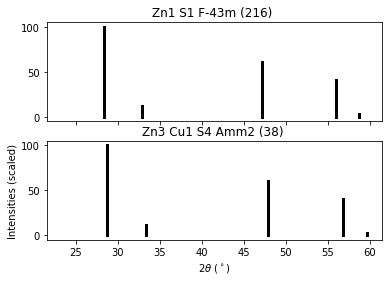

In [97]:
xrd_plots = xrd.plot_structures([structure, ordered_structure_guess], annotate_peaks=False, two_theta_range=[20,60])

you can see how the peaks shift slightly to the right with Cu integration!

In [ ]:
# other properties?

# Test your skills

Now, try this exercise on a structure of interest to you!

In [84]:
# TBD